In [210]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset,DataLoader
from ucimlrepo import fetch_ucirepo 
import matplotlib.pyplot as plt
import matplotlib_inline
import seaborn as sns
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

import torch
import torch.nn as nn
import torch.nn.functional as F

In [211]:
### comment this line for development
import warnings
# Suppress all warnings from pandas
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

In [212]:
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes) 
X = heart_disease.data.features 
y = heart_disease.data.targets 

X.head()
# y.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0


In [213]:
X.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,301.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,4.734219
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438,1.939706
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000


In [214]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
dtypes: float64(3), int64(10)
memory usage: 30.9 KB


In [215]:
# summary of null values
null_summary = X.isnull().any()

null_summary

age         False
sex         False
cp          False
trestbps    False
chol        False
fbs         False
restecg     False
thalach     False
exang       False
oldpeak     False
slope       False
ca           True
thal         True
dtype: bool

In [216]:
null_columns = []
for (key, value) in null_summary.items():
    
    if value:
        nan_or_null_val = X[key].isnull().sum()
        print(f"{key} feature: {nan_or_null_val}")
        null_columns.append(key)

ca feature: 4
thal feature: 2


In [217]:
for column in null_columns:
    mode = X[column].mode()[0]
    X[column] = X[column].fillna(value=mode)


In [218]:
X.isnull().any()

age         False
sex         False
cp          False
trestbps    False
chol        False
fbs         False
restecg     False
thalach     False
exang       False
oldpeak     False
slope       False
ca          False
thal        False
dtype: bool

In [219]:
# Concatenate column-wise
df = pd.concat([X, y], axis=1)  # axis=1 concatenates along columns
# pairplot = sns.pairplot(df,kind='reg',hue="num")
# Save the plot to a file
# pairplot.savefig('pairplot.png')
# plt.show()

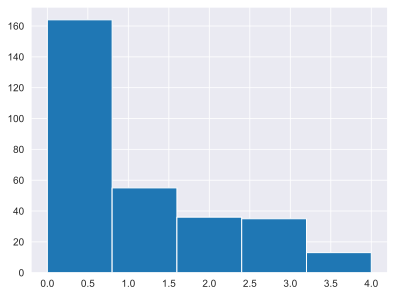

In [220]:
plt.hist(y,bins=5)
plt.show()

In [221]:
## creating only two category
y.iloc[np.where(y['num'] >= 1)] = 1

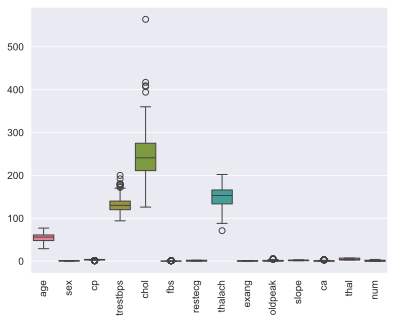

In [222]:
### searching for outliers
sns.boxplot(df)
plt.xticks(rotation=90)
plt.show()

In [237]:
# Columns to exclude from z-normalizing
exclude_columns = ['sex', 'fbs','exang']

#### uncomment this for developing purpose
# Apply z-score only to the specified columns
# X_norm = X.copy()  # Create a copy of the original DataFrame to preserve it
# X_norm.loc[:, ~X.columns.isin(exclude_columns)] = X.loc[:, ~X.columns.isin(exclude_columns)].apply(stats.zscore)

X_norm.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,0.948726,1,-2.251775,0.757525,-0.264900,1,1.016684,0.017197,0,1.087338,2.274579,-0.711131,0.660004
1,1.392002,1,0.877985,1.611220,0.760415,0,1.016684,-1.821905,1,0.397182,0.649113,2.504881,-0.890238
2,1.392002,1,0.877985,-0.665300,-0.342283,0,1.016684,-0.902354,1,1.346147,0.649113,1.432877,1.176752
3,-1.932564,1,-0.165268,-0.096170,0.063974,0,-0.996749,1.637359,0,2.122573,2.274579,-0.711131,-0.890238
4,-1.489288,0,-1.208521,-0.096170,-0.825922,0,1.016684,0.980537,0,0.310912,-0.976352,-0.711131,-0.890238
5,0.172994,1,-1.208521,-0.665300,-0.206864,0,-0.996749,1.243266,0,-0.206705,-0.976352,-0.711131,-0.890238
6,0.837908,0,0.877985,0.472960,0.412195,0,1.016684,0.455079,0,2.208842,2.274579,1.432877,-0.890238
7,0.283813,0,0.877985,-0.665300,2.075914,0,-0.996749,0.586443,1,-0.379244,-0.976352,-0.711131,-0.890238
8,0.948726,1,0.877985,-0.096170,0.141357,0,1.016684,-0.114167,0,0.310912,0.649113,0.360873,1.176752
9,-0.159462,1,0.877985,0.472960,-0.845268,1,1.016684,0.236138,1,1.777495,2.274579,-0.711131,1.176752


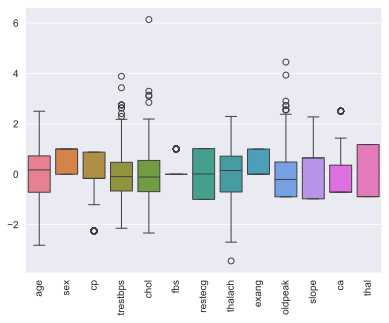

In [224]:
### searching for outliers
sns.boxplot(X_norm)
plt.xticks(rotation=90)
plt.show()

In [225]:
### removing outlier
# Get the indices of rows where 'chol' > 4
outlier_indices = np.where(X_norm['chol'] > 4)[0]

# Drop the rows using these indices
X_norm = X_norm.drop(index=X_norm.index[outlier_indices])

y = y.drop(index=y.index[outlier_indices])

print(y.shape)
print(X_norm.shape)

(302, 1)
(302, 13)


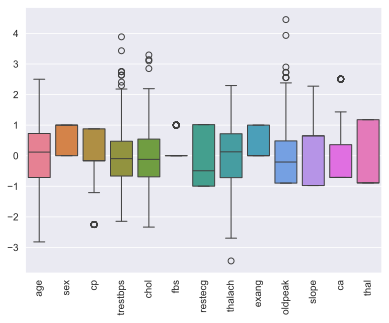

In [226]:
### searching for outliers
sns.boxplot(X_norm)
plt.xticks(rotation=90)
plt.show()

In [227]:
X_norm_np = X_norm.to_numpy()
y_np = y.to_numpy()

In [228]:
X_train,X_test,y_train,y_test= train_test_split(X_norm_np,y_np,test_size=50)

train_dataset = TensorDataset(torch.tensor(X_train).float(),torch.tensor(y_train).float())
test_dataset = TensorDataset(torch.tensor(X_test).float(),torch.tensor(y_test).float())

train_loader = DataLoader(dataset=train_dataset,batch_size=20,shuffle=True,drop_last=True)
test_loader = DataLoader(dataset=test_dataset,batch_size=test_dataset.tensors[0].shape[0])

## Creating Model

for now just copying the last project model , to see what happens. 

In [229]:
class Net(nn.Module):
    def __init__(self,nLayers,nUnits):
        super().__init__()
        
        self.layers = nn.ModuleDict()
        self.nLayers = nLayers
        # input layer
        self.layers["input"] = nn.Linear(13, nUnits)
        
        ### hidden layers
        for i in range(nLayers):
            self.layers["layer{}".format(i)] = nn.Linear(nUnits,nUnits)
        
        ### output layer
        self.layers["output"] = nn.Linear(nUnits,1)
        
    def forward(self,x):
        x = F.leaky_relu(self.layers["input"](x))
        
        for i in range(self.nLayers):
            x = F.leaky_relu(self.layers[f"layer{i}"](x))
            
        return self.layers["output"](x)
        

In [230]:
def createNet(nLayers,nUnits):
    
    net = Net(nLayers,nUnits)
    
    lossFn = nn.BCEWithLogitsLoss()
    
    optimizer = torch.optim.Adam(net.parameters(),lr=0.001)
    
    return net,lossFn,optimizer

In [231]:
def trainModel(nLayers,nUnits):
    
    # number of epochs
    num_epochs = 100
    
    #  create new model
    net, lossFn,optimizer = createNet(nLayers,nUnits)
    
    # init losses
    losses = torch.zeros(num_epochs)
    trainAcc = []
    testsetAcc = []
    
    # looping over epochs
    for epochI in range(num_epochs):
        net.train()
        # loop over batches
        batchAcc = []
        batchLoss = []
        for X,y in train_loader:
            
            # forward pass and loss
            yhat = net(X)
            loss = lossFn(yhat,y)
            
            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batchLoss.append(loss.item())
            
            # compute acc
            pred = (torch.sigmoid(yhat) > .5).float()
            batchAcc.append( 100*torch.mean((pred==y).float()) )
            # end of batch loop...
        
        trainAcc.append(np.mean(batchAcc))
        
        
        losses[epochI] = np.mean(batchLoss)
        
        net.eval()
        X,y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)
        
        # test accuracy
        predictions = (torch.sigmoid(yHat)>.5).float()
        testsetAcc.append( 100*torch.mean((predictions==y).float()) )
        
    return trainAcc,testsetAcc,losses,net

In [232]:
### testing class
net2 = Net(2,16)
X,y = next(iter(train_loader))
yHat = net2(X)

In [233]:
### testing train model
trainAcc,testsetAcc,losses,net = trainModel(2,16)

print(np.mean(trainAcc[-5:]))
print(np.mean(testsetAcc[-5:]))

94.5
81.2


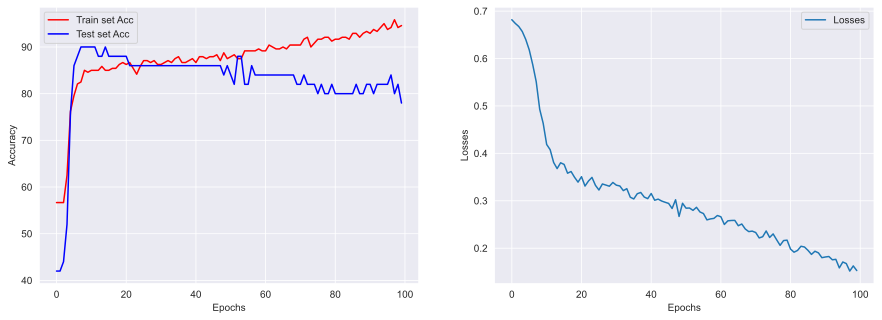

In [234]:
### randomly found 2 layers and 8 units lets plot it
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(trainAcc,'r-',label="Train set Acc")
ax[0].plot(testsetAcc,'b-',label="Test set Acc")
ax[0].set_ylabel("Accuracy")

ax[1].plot(losses,label="Losses")
ax[1].set_ylabel("Losses")

for axs in ax.flatten():
    axs.legend()
    axs.grid(True)
    axs.set_xlabel("Epochs")



plt.show()

In [235]:
### experiment parameter
layers_spect = np.arange(1,5)
units_spect = 2**np.arange(3,7)

ExpAcc = np.zeros((2,len(layers_spect),len(units_spect)),dtype=float)

# 
for layerI in range(len(layers_spect)):
#     
    for unitI in range(len(units_spect)):
#         
      trainAcc,testsetAcc,losses,net = trainModel(layers_spect[layerI],units_spect[unitI])
      
      ExpAcc[0,layerI,unitI] = np.mean(testsetAcc[:5])
      ExpAcc[1,layerI,unitI] = np.mean(trainAcc[:5])
      

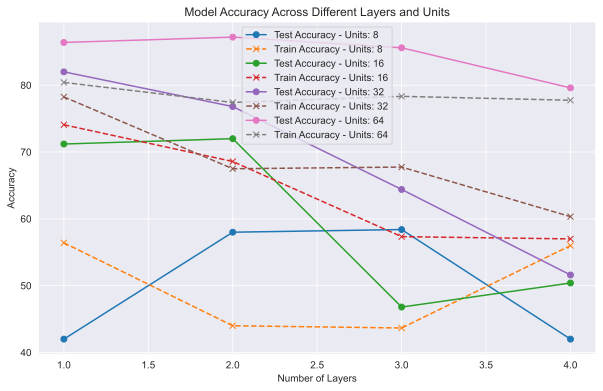

In [236]:
# Plotting
plt.figure(figsize=(10, 6))

for i, unit in enumerate(units_spect):
    plt.plot(
        layers_spect,
        ExpAcc[0, :, i],  # Mean test accuracy
        marker='o',
        label=f'Test Accuracy - Units: {unit}'
    )
    plt.plot(
        layers_spect,
        ExpAcc[1, :, i],  # Mean train accuracy
        marker='x',
        linestyle='--',
        label=f'Train Accuracy - Units: {unit}'
    )

plt.xlabel('Number of Layers')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Across Different Layers and Units')
plt.legend(loc='best')
plt.grid(True)
plt.show()